In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nxcals.api.extraction.data.builders import *
from scipy.optimize import curve_fit
from datetime import datetime
from madxtools.plot_tool import *
from madxtools.transfer_function import *
def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 18
    mpl.rcParams['axes.titlesize'] = 20  # Change the number for your preferred fontsize
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

In [140]:
start = "2022-11-27 11:00:00.000"
end = "2022-11-27 11:15:00.000"

selector = "CPS.USER.EAST4"

# Find the Brho through NXCALS

In [141]:
df = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("PR.BMEAS-B-ST/Samples").build().toPandas()
df['avg_flattop_Gauss'] = df['samples'].apply(lambda x: round(np.mean(x["elements"][10000:15000]), 1)) # Hardcoded flattop time

rho = 70.0789
mean_flattop_Bfield = np.mean(df[df.selector==selector].avg_flattop_Gauss) # in Gauss
Brho = rho*mean_flattop_Bfield/10000 * 54/82 # Because we are fully stripped 
print(f"Brho = {Brho}")

Brho = 14.315580952682927


# Dipoles and correctors

In [142]:
# Initialize an empty DataFrame
df_dipoles = pd.DataFrame()

magnet_names = ["F61.BHZ01.A/MEAS.PULSE",
                "F61.BHZ01.B/MEAS.PULSE",
               "F61.BHZ02.A/MEAS.PULSE",
                "F61.BHZ02.B/MEAS.PULSE",
               "T8.BHZ03/MEAS.PULSE",
               "T8.BHZ04/MEAS.PULSE",
               "T8.BHZ05/MEAS.PULSE",
                "F61.DHZ01/MEAS.PULSE",
                "F61.DVT01/MEAS.PULSE",
                "T8.DHZ02/MEAS.PULSE",
                "T8.DVT02/MEAS.PULSE",
                "T8.DVT03/MEAS.PULSE",
                "T8.DHZ03/MEAS.PULSE"]

for magnet_name in magnet_names:
    df = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter(magnet_name).build().toPandas()
    df = df[['VALUE', 'acqStamp', 'selector']]

    # Add a new column for the corrector name
    df['magnet_name'] = magnet_name
    
    # Add a column with timestamp in datetime format
    df["timestamp"] = pd.to_datetime(df['acqStamp'], unit='ns')
    df.sort_values(by="timestamp", inplace=True)

    # Append the DataFrame from this iteration to the combined DataFrame
    df_dipoles = df_dipoles.append(df)

# Reset the index of the final DataFrame
df_dipoles = df_dipoles[df_dipoles.selector == selector].reset_index(drop=True)


In [143]:
keys = ["F61.BHZ01.A/MEAS.PULSE", "F61.BHZ01.B/MEAS.PULSE", "F61.BHZ02.A/MEAS.PULSE", "F61.BHZ02.B/MEAS.PULSE", "T8.BHZ03/MEAS.PULSE", "T8.BHZ04/MEAS.PULSE","T8.BHZ05/MEAS.PULSE",   
    "F61.DHZ01/MEAS.PULSE", "F61.DVT01/MEAS.PULSE", "T8.DHZ02/MEAS.PULSE", "T8.DVT02/MEAS.PULSE", "T8.DVT03/MEAS.PULSE", "T8.DHZ03/MEAS.PULSE"]
values = ["MCB","MCB","MCB","MCB","MCB","MCB","MCB","CR200", "CR200", "MDXL150",  "MDXL150",  "MDXL150",  "MDXL150"]

mapping = dict(zip(keys, values))

# Create a new column with angle

# Create a column with magnet type
df_dipoles["type"] = df_dipoles['magnet_name'].map(mapping)

# Apply the angle function to each row and add results as a new column
df_dipoles['angle'] = df_dipoles.apply(lambda row: angle(row['VALUE'], row.type, Brho), axis=1)

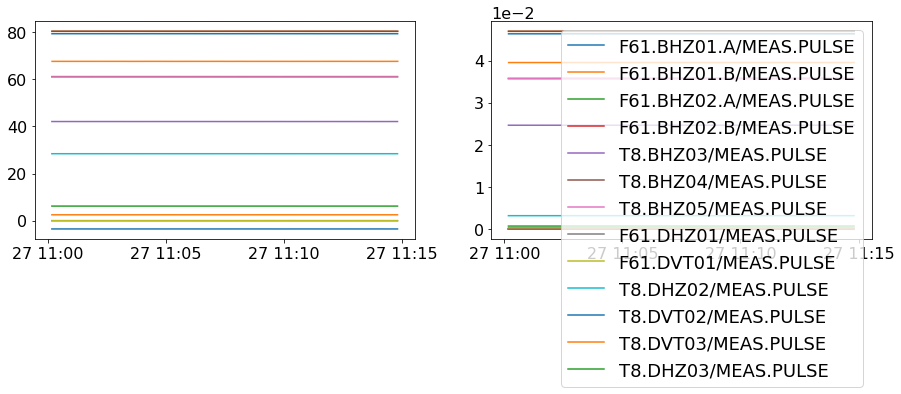

In [144]:
fig, ax = plt.subplots(1,2, figsize = (15,4))

for name in df_dipoles.magnet_name.unique():
    
    df_filtered = df_dipoles[ (df_dipoles.magnet_name == name)]
    ax[0].plot(df_filtered.timestamp, df_filtered.VALUE, label=name)
    ax[1].plot(df_filtered.timestamp, df_filtered.angle, label=name)

ax[1].legend()

In [145]:
print(start)
print(end)
print(selector)
print("")

for name in df_dipoles.magnet_name.unique():
    df_filtered = df_dipoles[(df_dipoles.magnet_name == name)]
    print(f"{name} {round(np.mean(df_filtered.angle),6)}")

2022-11-27 11:00:00.000
2022-11-27 11:15:00.000
CPS.USER.EAST4

F61.BHZ01.A/MEAS.PULSE 0.046351
F61.BHZ01.B/MEAS.PULSE 0.039528
F61.BHZ02.A/MEAS.PULSE 0.04695
F61.BHZ02.B/MEAS.PULSE 0.046951
T8.BHZ03/MEAS.PULSE 0.024641
T8.BHZ04/MEAS.PULSE 0.035765
T8.BHZ05/MEAS.PULSE 0.03567
F61.DHZ01/MEAS.PULSE 0.0
F61.DVT01/MEAS.PULSE 0.0
T8.DHZ02/MEAS.PULSE 0.003154
T8.DVT02/MEAS.PULSE 0.0
T8.DVT03/MEAS.PULSE 0.000278
T8.DHZ03/MEAS.PULSE 0.000688


# Quadrupoles

In [146]:
# Initialize an empty DataFrame
df_quadrupoles = pd.DataFrame()

magnet_names = ["F61.QFN01/MEAS.PULSE",
               "F61.QDN02/MEAS.PULSE",
               "F61.QFN03/MEAS.PULSE",
               "F61.QDN04/MEAS.PULSE",
               "T8.QFN05/MEAS.PULSE",
               "T8.QDN06/MEAS.PULSE",
               "T8.QDN07/MEAS.PULSE",
               "T8.QFN08/MEAS.PULSE"]

for magnet_name in magnet_names:
    df = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter(magnet_name).build().toPandas()
    df = df[['VALUE', 'acqStamp', 'selector']]

    # Add a new column for the corrector name
    df['magnet_name'] = magnet_name
    
    # Add a column with timestamp in datetime format
    df["timestamp"] = pd.to_datetime(df['acqStamp'], unit='ns')
    df.sort_values(by="timestamp", inplace=True)

    # Append the DataFrame from this iteration to the combined DataFrame
    df_quadrupoles = df_quadrupoles.append(df)

# Reset the index of the final DataFrame
df_quadrupoles = df_quadrupoles[df_quadrupoles.selector == selector].reset_index(drop=True)

In [147]:
keys = ["F61.QFN01/MEAS.PULSE",
        "F61.QDN02/MEAS.PULSE",
        "F61.QFN03/MEAS.PULSE",
        "F61.QDN04/MEAS.PULSE",
        "T8.QFN05/MEAS.PULSE",
        "T8.QDN06/MEAS.PULSE",
        "T8.QDN07/MEAS.PULSE",
        "T8.QFN08/MEAS.PULSE"]
values = ["Q74L","Q120C","QFL","QFS","QFL","QFL","Q200L","Q200L"]

mapping = dict(zip(keys, values))

# Create a new column with K1

# Create a column with magnet type
df_quadrupoles["type"] = df_quadrupoles['magnet_name'].map(mapping)

# Apply the k1 function to each row and add results as a new column
df_quadrupoles['k1'] = df_quadrupoles.apply(lambda row: k1(row['VALUE'], row.type, Brho=Brho*82/54) if row.magnet_name == "F61.QFN01/MEAS.PULSE" else k1(row['VALUE'], row.type, Brho), axis=1)

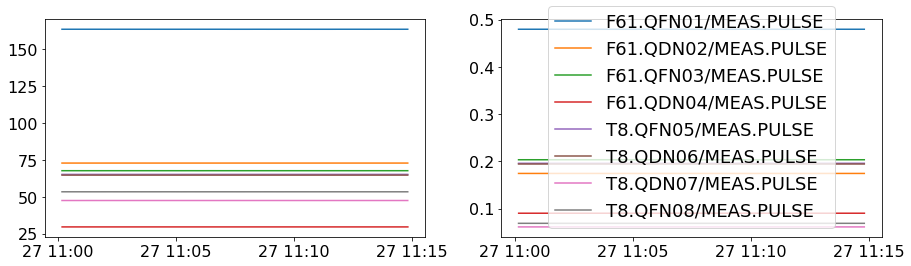

In [148]:
fig, ax = plt.subplots(1,2, figsize = (15,4))

for name in df_quadrupoles.magnet_name.unique():
    
    df_filtered = df_quadrupoles[ (df_quadrupoles.magnet_name == name)]
    ax[0].plot(df_filtered.timestamp, df_filtered.VALUE, label=name)
    ax[1].plot(df_filtered.timestamp, df_filtered.k1, label=name)

ax[1].legend()

In [149]:
print(start)
print(end)
print(selector)
print("")

for name in df_quadrupoles.magnet_name.unique():
    df_filtered = df_quadrupoles[(df_quadrupoles.magnet_name == name)]
    print(f"{name} {round(np.mean(df_filtered.k1),6)}")

2022-11-27 11:00:00.000
2022-11-27 11:15:00.000
CPS.USER.EAST4

F61.QFN01/MEAS.PULSE 0.47953
F61.QDN02/MEAS.PULSE 0.174523
F61.QFN03/MEAS.PULSE 0.20349
F61.QDN04/MEAS.PULSE 0.090367
T8.QFN05/MEAS.PULSE 0.195973
T8.QDN06/MEAS.PULSE 0.194472
T8.QDN07/MEAS.PULSE 0.061402
T8.QFN08/MEAS.PULSE 0.068996


# Presentation

In [150]:
print(start)
print(end)
print(selector)
print("")

d = {'name': [], 'angle': []}
df_dipole_avg = pd.DataFrame(data=d)
print("Dipoles avg angle [rad]")
for name in df_dipoles.magnet_name.unique():
    df_filtered = df_dipoles[(df_dipoles.magnet_name == name) & (df_dipoles.type == "MCB")]
    if not df_filtered.empty:
        print(f"{name} {round(np.mean(df_filtered.angle),6)}")
        d = {'name': [name], 'angle': [np.mean(df_filtered.angle)]}
        df = pd.DataFrame(data=d)
        df_dipole_avg = pd.concat([df_dipole_avg,df])
        

d = {'name': [], 'angle': []}
df_corrector_avg = pd.DataFrame(data=d)
print("")
print("Correctors avg angle [rad]")
for name in df_dipoles.magnet_name.unique():
    df_filtered = df_dipoles[(df_dipoles.magnet_name == name) & (df_dipoles.type != "MCB")]
    if not df_filtered.empty:
        print(f"{name} {round(np.mean(df_filtered.angle),6)}")
        d = {'name': [name], 'angle': [np.mean(df_filtered.angle)]}
        df = pd.DataFrame(data=d)
        df_corrector_avg = pd.concat([df_corrector_avg,df])

d = {'name': [], 'angle': []}
df_quadrupole_avg = pd.DataFrame(data=d)
print("")
print("Quadrupoles avg K1 [1/m^2]")
for name in df_quadrupoles.magnet_name.unique():
    df_filtered = df_quadrupoles[(df_quadrupoles.magnet_name == name)]
    print(f"{name} {round(np.mean(df_filtered.k1),6)}")
    d = {'name': [name], 'angle': [np.mean(df_filtered.k1)]}
    df = pd.DataFrame(data=d)
    df_quadrupole_avg = pd.concat([df_quadrupole_avg,df])
    
df_dipole_avg.set_index('name', inplace=True)
df_corrector_avg.set_index('name', inplace=True)
df_quadrupole_avg.set_index('name', inplace=True)

2022-11-27 11:00:00.000
2022-11-27 11:15:00.000
CPS.USER.EAST4

Dipoles avg angle [rad]
F61.BHZ01.A/MEAS.PULSE 0.046351
F61.BHZ01.B/MEAS.PULSE 0.039528
F61.BHZ02.A/MEAS.PULSE 0.04695
F61.BHZ02.B/MEAS.PULSE 0.046951
T8.BHZ03/MEAS.PULSE 0.024641
T8.BHZ04/MEAS.PULSE 0.035765
T8.BHZ05/MEAS.PULSE 0.03567

Correctors avg angle [rad]
F61.DHZ01/MEAS.PULSE 0.0
F61.DVT01/MEAS.PULSE 0.0
T8.DHZ02/MEAS.PULSE 0.003154
T8.DVT02/MEAS.PULSE 0.0
T8.DVT03/MEAS.PULSE 0.000278
T8.DHZ03/MEAS.PULSE 0.000688

Quadrupoles avg K1 [1/m^2]
F61.QFN01/MEAS.PULSE 0.47953
F61.QDN02/MEAS.PULSE 0.174523
F61.QFN03/MEAS.PULSE 0.20349
F61.QDN04/MEAS.PULSE 0.090367
T8.QFN05/MEAS.PULSE 0.195973
T8.QDN06/MEAS.PULSE 0.194472
T8.QDN07/MEAS.PULSE 0.061402
T8.QFN08/MEAS.PULSE 0.068996


Text(0.5, 1.0, 'Quadrupoles')

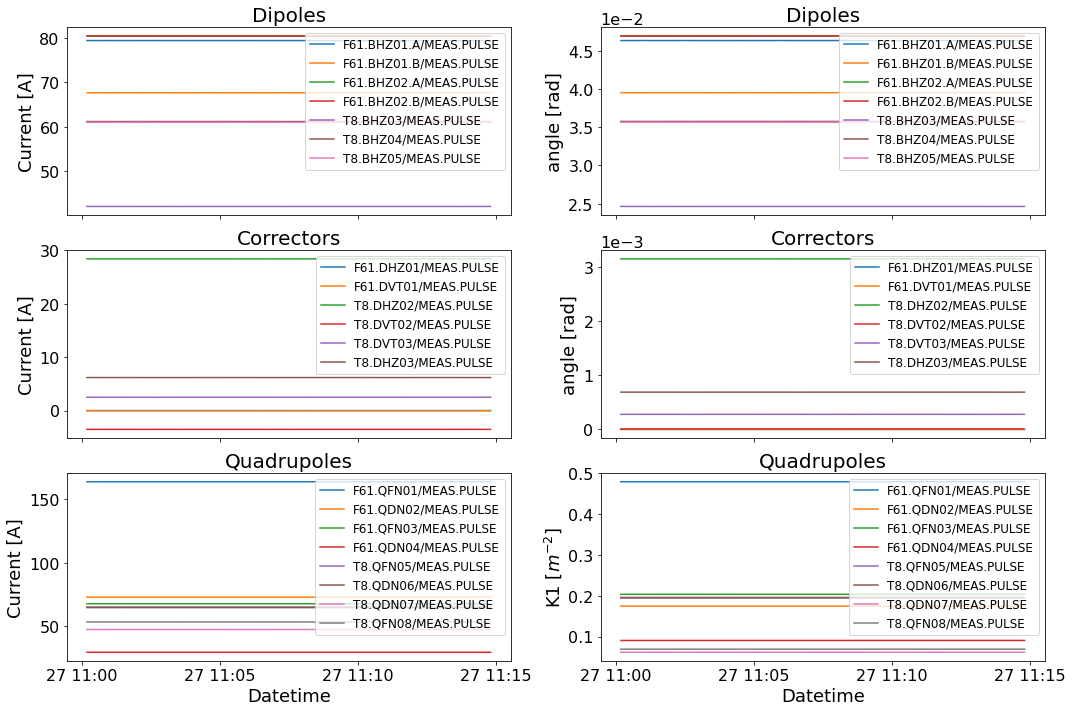

In [151]:
fig, ax = plt.subplots(3,2, figsize = (15,10), sharex=True, tight_layout=True)

fontsize = 12

dipole_names = ["F61.BHZ01.A/MEAS.PULSE",
                "F61.BHZ01.B/MEAS.PULSE",
               "F61.BHZ02.A/MEAS.PULSE",
                "F61.BHZ02.B/MEAS.PULSE",
               "T8.BHZ03/MEAS.PULSE",
               "T8.BHZ04/MEAS.PULSE",
               "T8.BHZ05/MEAS.PULSE"]

for name in dipole_names:
    
    df_filtered = df_dipoles[ (df_dipoles.magnet_name == name)]
    ax[0,0].plot(df_filtered.timestamp, df_filtered.VALUE, label=name)
    ax[0,1].plot(df_filtered.timestamp, df_filtered.angle, label=name)

ax[0,0].legend(fontsize=fontsize, loc="upper right")
ax[0,1].legend(fontsize=fontsize, loc="upper right")

corrector_names = ["F61.DHZ01/MEAS.PULSE",
                "F61.DVT01/MEAS.PULSE",
                "T8.DHZ02/MEAS.PULSE",
                "T8.DVT02/MEAS.PULSE",
                "T8.DVT03/MEAS.PULSE",
                "T8.DHZ03/MEAS.PULSE"]

for name in corrector_names:
    
    df_filtered = df_dipoles[ (df_dipoles.magnet_name == name)]
    ax[1,0].plot(df_filtered.timestamp, df_filtered.VALUE, label=name)
    ax[1,1].plot(df_filtered.timestamp, df_filtered.angle, label=name)

ax[1,0].legend(fontsize=fontsize, loc="upper right")
ax[1,1].legend(fontsize=fontsize, loc="upper right")


quadrupole_names = ["F61.QFN01/MEAS.PULSE",
               "F61.QDN02/MEAS.PULSE",
               "F61.QFN03/MEAS.PULSE",
               "F61.QDN04/MEAS.PULSE",
               "T8.QFN05/MEAS.PULSE",
               "T8.QDN06/MEAS.PULSE",
               "T8.QDN07/MEAS.PULSE",
               "T8.QFN08/MEAS.PULSE"]

for name in quadrupole_names:
    
    df_filtered = df_quadrupoles[ (df_quadrupoles.magnet_name == name)]
    ax[2,0].plot(df_filtered.timestamp, df_filtered.VALUE, label=name)
    ax[2,1].plot(df_filtered.timestamp, df_filtered.k1, label=name)

ax[2,0].legend(fontsize=fontsize, loc="upper right")
ax[2,1].legend(fontsize=fontsize, loc="upper right")


ax[2,0].set_xlabel("Datetime")
ax[2,1].set_xlabel("Datetime")

ax[0,0].set_ylabel("Current [A]")
ax[1,0].set_ylabel("Current [A]")
ax[2,0].set_ylabel("Current [A]")

ax[0,1].set_ylabel(r"angle [rad]")
ax[1,1].set_ylabel(r"angle [rad]")
ax[2,1].set_ylabel(r"K1 [$m^{-2}$]")

# Titles
ax[0,0].set_title("Dipoles")
ax[0,1].set_title("Dipoles")

ax[1,0].set_title("Correctors")
ax[1,1].set_title("Correctors")

ax[2,0].set_title("Quadrupoles")
ax[2,1].set_title("Quadrupoles")

# Now that I have the values I can run them in a twiss

In [170]:
# Beam characteristics
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Initial conditions
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

#################################### Initialize MADX ############################################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L, DELTAP, BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input("kQFN1 = "+str(df_quadrupole_avg.loc["F61.QFN01/MEAS.PULSE"].angle)+";")
madx.input("kQDN2 = "+str(-df_quadrupole_avg.loc["F61.QDN02/MEAS.PULSE"].angle)+";")
madx.input("kQFN3 = "+str(df_quadrupole_avg.loc["F61.QFN03/MEAS.PULSE"].angle)+";")
madx.input("kQDN4 = "+str(-df_quadrupole_avg.loc["F61.QDN04/MEAS.PULSE"].angle)+";")
madx.input("kQFN5 = "+str(df_quadrupole_avg.loc["T8.QFN05/MEAS.PULSE"].angle)+";")
madx.input("kQDN6 = "+str(-df_quadrupole_avg.loc["T8.QDN06/MEAS.PULSE"].angle)+";")
madx.input("kQDN7 = "+str(-df_quadrupole_avg.loc["T8.QDN07/MEAS.PULSE"].angle)+";")
madx.input("kQFN8 = "+str(df_quadrupole_avg.loc["T8.QFN08/MEAS.PULSE"].angle)+";")

############################################################################################################

madx.use(sequence="f61t8_op")


start_datetime = datetime.strptime(start, '%Y-%m-%d %H:%M:%S.%f')
formatted_start = start_datetime.strftime('%Y_%m_%d_%H_%M_%S')
end_datetime = datetime.strptime(end, '%Y-%m-%d %H:%M:%S.%f')
formatted_end = end_datetime.strftime('%Y_%m_%d_%H_%M_%S')


twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0, file="twiss_"+str(formatted_start)+"_to_"+str(formatted_end)+"_"+(selector.replace(".","_"))+".twiss").dframe()

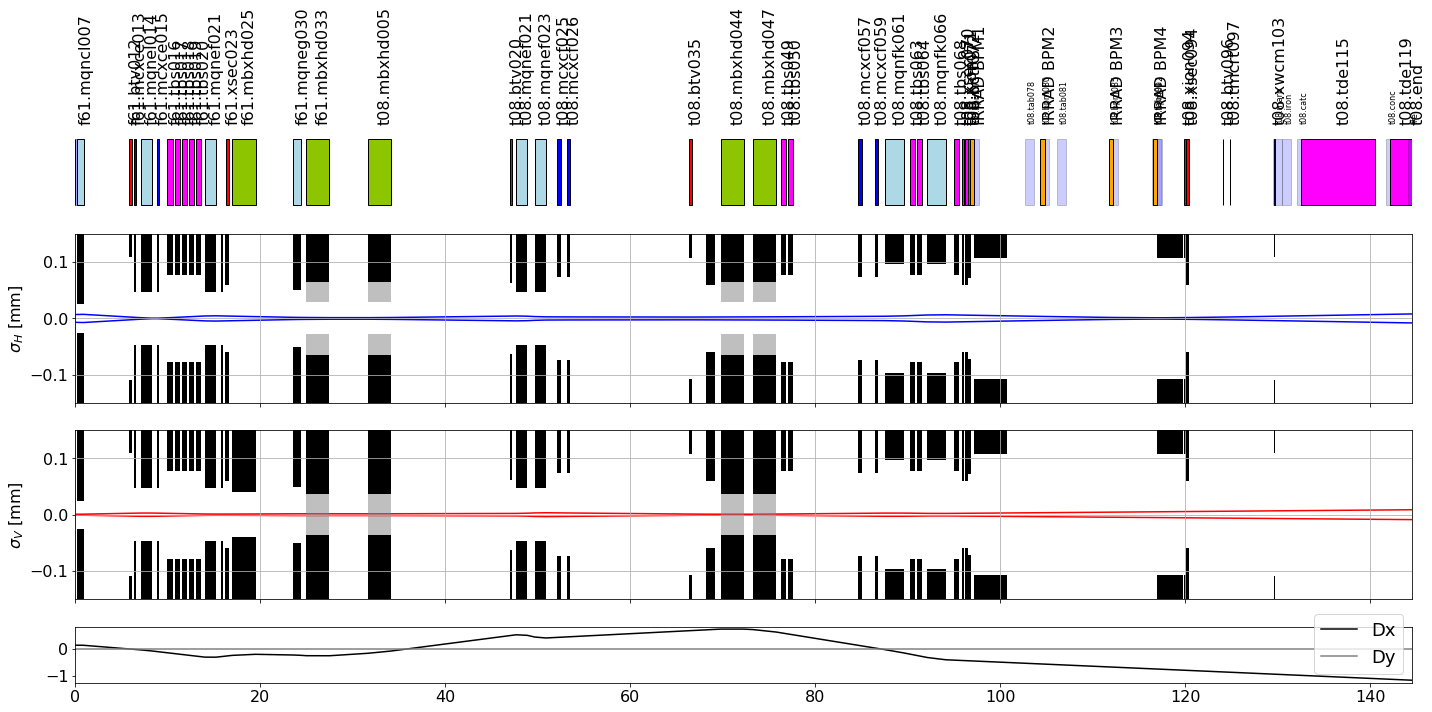

In [157]:
 fontsize = 16

fig, ax = plt.subplots(4,1, figsize=(20,10), tight_layout=True, sharex=True, height_ratios=[2,3,3,1])

draw_synoptic(ax[0], twiss)
ax[0].set_xlim(0,twiss.s[-1])
ax[0].set_ylim(-0.01,1.)
ax[0].axis("off")

ax[1].plot(twiss['s'], beam_size(twiss['betx'], twiss['dx'], ex, sige, 1), alpha=1.0, color ="b", zorder=0)
ax[1].plot(twiss['s'], -beam_size(twiss['betx'], twiss['dx'], ex, sige, 1), alpha=1.0, color ="b", zorder=0)

ax[1].set_xlim(0,twiss.s[-1])

ax[2].plot(twiss['s'], beam_size(twiss['bety'], twiss['dy'], ey, sige, 1), alpha=1.0, color ="r", zorder=0)
ax[2].plot(twiss['s'], -beam_size(twiss['bety'], twiss['dy'], ey, sige, 1), alpha=1.0, color ="r", zorder=0)

draw_aperture_circle(ax[1], twiss, "aper_1")
draw_aperture_circle(ax[2], twiss, "aper_1")
draw_aperture_rectangle(ax[1], twiss, "aper_1")
draw_aperture_rectangle(ax[2], twiss, "aper_2")
draw_aperture_racetrackH(ax[1], twiss, "aper_1", "aper_2", "aper_3", "aper_4")
draw_aperture_racetrackV(ax[2], twiss, "aper_1", "aper_2", "aper_3", "aper_4")

ax[2].set_xlim(0,twiss.s[-1])

ax[1].grid()
ax[1].set_ylim(-0.15, 0.15)
ax[1].set_ylabel(r"$\sigma_{H}$ [mm]", fontsize=fontsize)

ax[2].grid()
ax[2].set_ylim(-0.15, 0.15)
ax[2].set_ylabel(r"$\sigma_{V}$ [mm]", fontsize=fontsize)

ax[3].plot(twiss['s'], twiss['dx'], alpha=1.0, color ="k", zorder=0, label = "Dx")
ax[3].plot(twiss['s'], twiss['dy'], alpha=1.0, color ="gray", zorder=0, label = "Dy")
ax[3].legend()